In [647]:
import importlib

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import sympy as sm
import sympy.physics.mechanics as me

import robot


%config InlineBackend.figure_formats = ['svg']
me.functions.mechanics_printing(use_latex="mathjax", latex_mode="equation")

In [648]:
importlib.reload(robot)
r = robot.SerialRobot()

### The step 2
- Jumping using the slide joint.
- The state vector $y = (\theta_1, \theta_2, x, \dot{\theta}_1, \dot{\theta}_2, \dot{x})$.
- Assumes that $x(t)$ is given.
    - Thus, $\dot{x}(t)$ and $\ddot{x}(t)$ are known too.
- The equations of motion is a system of linear equations of 5 variables $\ddot{\theta}_1$, $\ddot{\theta}_2$, $\ddot{x}$, $u_1$, and $u_2$.
    - The EoM gives 3 linear equations.
    - When 2 of 5 variables are specified, the rest of them can be determined.
- One sensible example would be the case that $\ddot{x}$ and $u_1$ are specified.
- Negative generalized force (contraction force) for $x$ is not realizable since it is friction based.
    - `scipy.integrate.solve_ivp` can detect the event!

Text(0.5, 0, 't (s)')

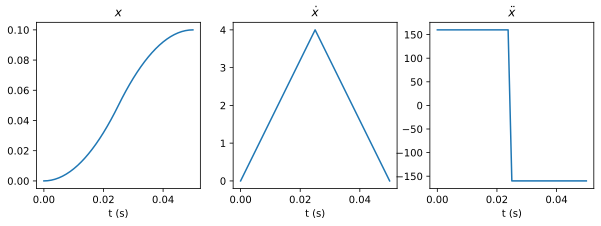

In [649]:
ms = 1e-3

tf = 50 * ms
delx = 0.1


def ref_x(t):
    return (delx * (t / (tf / 2))**2 / 2) if (t < tf / 2) else (delx - delx * ((tf - t) / (tf / 2))**2 / 2)


def ref_dx(t):
    return delx * t / (tf / 2)**2 if (t < tf / 2) else delx * (tf - t) / (tf / 2)**2


def ref_ddx(t):
    return delx / (tf / 2)**2 if (t < tf / 2) else -delx / (tf / 2)**2


fig, ax = plt.subplots(1, 3, figsize=(10, 3))

ts = np.linspace(0, tf, 41)

ax[0].plot(ts, [ref_x(t) for t in ts])
ax[0].set_title(r'$x$')
ax[0].set_xlabel('t (s)')

ax[1].plot(ts, [ref_dx(t) for t in ts])
ax[1].set_title(r'$\dot{x}$')
ax[1].set_xlabel('t (s)')

ax[2].plot(ts, [ref_ddx(t) for t in ts])
ax[2].set_title(r'$\ddot{x}$')
ax[2].set_xlabel('t (s)')

In [650]:
physical_params = {
    r.g: 9.8,
    r.la: 1,
    r.lb: 0.2,
    r.ma: 1,
    r.mb: 5,
    r.Ia: 1,
    r.Ib: 5,
}

### Solve the equations of motion for $\ddot{\theta}_1$, $\ddot{\theta}_2$, and $u_x$ for a given $x(t)$.
- The EoM give
    - $\ddot{\theta}_1 = f_{\theta_1}(y, u_{\theta_2}, \ddot{x})$, $\ddot{\theta}_2 = f_{\theta_2}(y, u_{\theta_2}, \ddot{x})$, and $u_x = f_{u_x}(y, u_{\theta_2}, \ddot{x})$.
    - Here, $y = (\theta_1, \theta_2, x, \dot{\theta}_1, \dot{\theta}_2, \dot{x})$.
    - You can integrate $\dot{y}(t)$.
    - $u_{\theta_1} = u_{\theta_2} = 0$ and $\ddot{x}(t)$ is given instead of $u_x(t)$.
        - No actuations for revolute joints.
        - Only thrust actuations!


In [651]:
sol = sm.solve(
    r.eom.subs(physical_params),
    [r.ddth1, r.ddth2, r.ux],  # r.uth2 and r.ddx will be specified.
)

In [652]:
state_vec = [r.th1, r.th2, r.x, r.dth1, r.dth2, r.dx]


def f(t, y):
    """
    It assumes that u_{\theta_2} = 0, which is the actuation for the \theta_2.

    Parameters
    ----------
    t (float): Time.
    y (ndarray): The state vector y = (th1, th2, x, dth1, dth2, dx).
    """
    return np.concatenate([
        y[3:],
        [float(me.msubs(sol[var], {**{k: v for k, v in zip(state_vec, y)},
                                   **{r.ddx: ref_ddx(t), r.uth2: 0.}}))
         for var in [r.ddth1, r.ddth2]],
        [ref_ddx(t)],
    ])


def liftoff(t, y):
    """
    A negative generalized force for x is not attainable.

    Parameters
    ----------
    t (float): Time
    y (ndarray): The state vector y = (th1, th2, x, dth1, dth2, dx).
    """
    return float(me.msubs(sol[r.ux], {**{k: v for k, v in zip(state_vec, y)}, **{r.ddx: ref_ddx(t), r.uth2: 0}}))


liftoff.terminal = True
# The negative u2 indicates an contraction force, which is not attainable.
liftoff.direction = -1.

In [653]:
import scipy as sp

# The final state of the first step.
y1 = np.asarray([0.28659686,  -0.195, 0, 0.34771251, 0.5, 0])
y1 = np.asarray([1.53307259e-01, 1.48769950e-07, 0, 4.69319379e-01, 7.91469051e-09, 0])

traj_2 = sp.integrate.solve_ivp(f, (0, tf), y1, t_eval=np.linspace(0, tf, 51), events=liftoff)
traj_2.status == 1  # indicates the terminating condition is met.

True

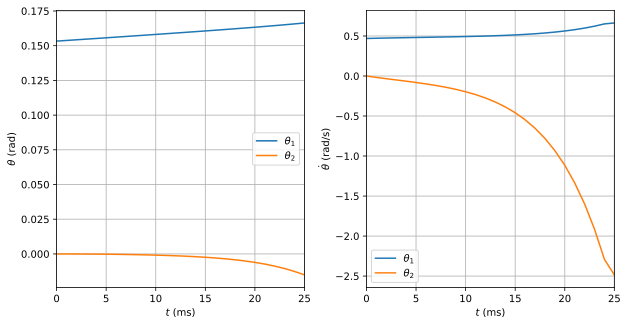

In [654]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.25)

ax[0].plot(traj_2.t * 1000, traj_2.y[0], label=r'$\theta_1$')
ax[0].plot(traj_2.t * 1000, traj_2.y[1], label=r'$\theta_2$')
ax[0].set_ylabel(r'$\theta$ (rad)')
               
ax[1].plot(traj_2.t * 1000, traj_2.y[3], label=r'$\theta_1$')
ax[1].plot(traj_2.t * 1000, traj_2.y[4], label=r'$\theta_2$')
ax[1].set_ylabel(r'$\dot{\theta}$ (rad/s)')

for a in ax:
    a.grid()
    a.legend()
    a.set_xlabel('$t$ (ms)')
    a.set_xlim(traj_2.t[0], traj_2.t[-1] / ms)

- A thust gives the negative momentum for $\theta_2$.
    - If a positive $\dot{\theta}_2$ is necessary during flight, it needs to be prepare a well positive $\dot{\theta}_2$ before the take-off.

### The velocity of the center of mass of the first link at the lift-off.
- With respect to the frame `N`.
- `traj_2.y[:, -6]` gives the state vector of the robot just before the lift-off.

In [655]:
state_vec = [r.th1, r.th2, r.x, r.dth1, r.dth2, r.dx]

final_y = traj_2.y[:, -1]

# The position of the CoM of the link la.
yq1 = float(r.Pa.pos_from(r.O).dot(r.N.x).subs(physical_params).subs({k: v for k, v in zip(state_vec, final_y)}))
yq2 = float(r.Pa.pos_from(r.O).dot(r.N.z).subs(physical_params).subs({k: v for k, v in zip(state_vec, final_y)}))
yth1 = final_y[0]
yth2 = final_y[1]
# The velocity of the CoM of the link la.
ydq1 = float(r.N.x.dot(r.Pa.vel(r.N)).subs(physical_params).subs({k: v for k, v in zip(state_vec, final_y)}))
ydq2 = float(r.N.z.dot(r.Pa.vel(r.N)).subs(physical_params).subs({k: v for k, v in zip(state_vec, final_y)}))
ydth1 = final_y[3]
ydth2 = final_y[4]

## The initial state for the step 3.
y2 = np.asarray((yq1, yq2, yth1, yth2, ydq1, ydq2, ydth1, ydth2))


### The step 3
- The robot flies after the lift-off for a brief moment.
- $x$ is a kinematic parameter during this stage of planning.
    - I gave 0 mass for this part of the robot.
    - Thus, it is dropped from the equations of motion.
- The state vector $ y = (q_1, q_2, \theta_1, \theta_2, \dot{q}_1, \dot{q}_2, \dot{\theta}_1, \dot{\theta}_2)$ is specified.
- $\theta_2(t)$ is also specified for landing.
    - $u_{\theta_2}$ can be calculated.
- `scipy.integrate.solve_ivp` needs to detects the touch-down.
    - The event method the calculate the z componenet of the tip of the leg.
        - `z = r.Pe.pos_from(r.O).dot(r.N.z)`
    - `terminal=True` and `direction=-1.`.

In [656]:
r2 = robot.FlyingRobot()

In [657]:
r2.Pe.pos_from(r2.O).dot(r2.N.x).subs(physical_params).subs({k: v for k, v in zip(state_vec, traj_2.y[:, -1])})

q₁ - 0.0910841046523462

In [658]:
r2.eom

⎡                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                      ⎛lₐ⋅(-s ↪
⎢                           

(0.0, 1.0)

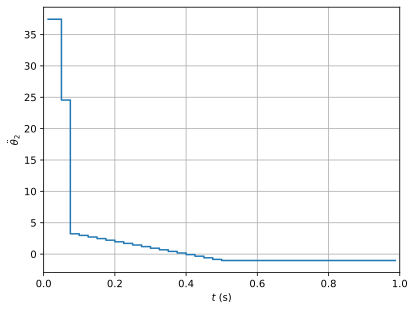

In [659]:
n = 40
# This problem considers n time intervals. They are (ts[0, ts[1]), ..., (ts[n - 1], ts[n]).
# But n + 1 knots.
ts = np.linspace(0, 1, n + 1)

# accs[j] is the acceleration during (ts[j], ts[j + 1]).
accs = cp.Variable(n)

# (V @ accs) are expressions for the velocities at the ends of time intervals.
# (S @ accs) are expressions for the distances it travels at the ends of the time intervals.
V = np.zeros((n, n))
S = np.zeros((n, n))

for i in range(n):
    # Note that vels[i] and ss[i] depends only on accs[j] for j <= i.
    for j in range(i + 1):
        V[i, j] = ts[j + 1] - ts[j]
        S[i, j] = (ts[j + 1] - ts[j])**2 / 2 + V[i, j] * (ts[i + 1] - ts[j + 1])


s0, v0 = traj_2.y[1, -1], traj_2.y[4, -1]
vels = V @ accs + v0
ss = S @ accs + s0 + v0 * ts[1:]

constraints = [vels[-1] == 0, ss[-1] == 0.2]
prob = cp.Problem(cp.Minimize(cp.sum(cp.abs(accs[1:] - accs[:-1])) + cp.sum(accs**2) * 0.01 + cp.sum(cp.abs(vels)) * 10), constraints)
prob.solve()

fig, ax = plt.subplots()
# ax.plot((ts[:-1] + ts[1:]) / 2, accs.value, '.')
ax.step((ts[:-1] + ts[1:]) / 2, accs.value, where='mid')

ax.grid()

ax.set_xlabel(r'$t$ (s)')
ax.set_ylabel(r'$\ddot{\theta}_2$')

ax.set_xlim(0, 1)

(0.0, 1.0)

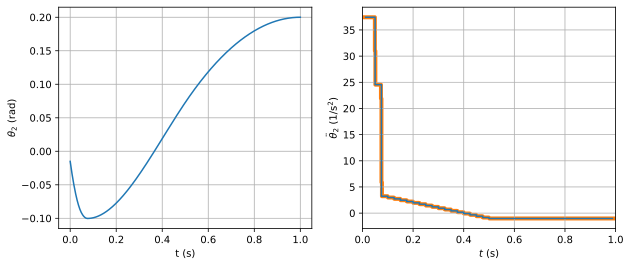

In [660]:
import bisect


def pos(t):
    idx = np.digitize(t, ts)

    if idx >= ts.shape[0]:
        # Assumes that the acceleration vanishes after t_f.
        return ss.value[-1] + (t - ts[-1]) * vels.value[-1]

    # Note that ts[idx - 1] <= t < ts[idx].
    # v = vels.value[idx - 2] at t = ts[idx - 1].
    # And it accelerate for dt with a rate of accs.value[idx - 1].
    dt = t - ts[idx - 1]
    
    s, v =  (ss.value[idx - 2], vels.value[idx - 2]) if idx > 1 else (s0, v0)
    a = accs.value[idx - 1]

    return s + v * dt + a * dt**2 / 2


int_ts = np.linspace(0, 1, 501)
ys = [pos(t) for t in int_ts]

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax.plot(int_ts, ys)

ax.grid()

ax.set_xlabel('t (s)')
ax.set_ylabel(r'$\theta_2$ (rad)')

# Just to make sure S and V matrices are correct.
ax2.step((ts[:-1] + ts[1:]) / 2, accs.value, where='mid')
ax2.step(int_ts[1:-1], np.diff(ys, 2) / (int_ts[1] - int_ts[0])**2, lw=4, zorder=-10, where='mid')
ax2.grid()

ax2.set_xlabel(r'$t$ (s)')
ax2.set_ylabel(r'$\ddot{\theta}_2$ (1/s$^2$)')

ax2.set_xlim(0, 1)


In [661]:
sol = sm.solve(r2.eom.subs(physical_params), [r2.ddq1, r2.ddq2, r2.ddth1, r2.uth2])

sol = {k: v.simplify().trigsimp() for k, v in sol.items()}

In [662]:
# Integrate the equations of motion.
state_vec = [r2.q1, r2.q2, r2.th1, r2.th2, r2.dq1, r2.dq2, r2.dth1, r2.dth2]
ys = [y2, ]


def touchdown(_, y):
    return float(r2.Pe.pos_from(r2.O).dot(r2.N.z).subs(physical_params).subs({k: v for k, v in zip(state_vec, y)}).subs({r2.x: 0.1}))


touchdown.terminal = True
touchdown.direction = -1

for idx, (a, b) in enumerate(zip(ts[:-1], ts[1:])):
    
    def f(_, y):
        """
        Parameters
        ----------
        _ (float): Time.
        y (ndarray): The state vector (q1, q2, th1, th2, dq1, dq2, dth1, dth2).
        """
        ddth2 = accs.value[idx]
        subs_dict = {k: v for k, v in zip(state_vec, y)}
        subs_dict[r2.ddth2] = ddth2
        
        return np.asarray([
            y[4], y[5], y[6], y[7],
            sol[r2.ddq1].subs(subs_dict),
            sol[r2.ddq2].subs(subs_dict),
            sol[r2.ddth1].subs(subs_dict),
            a,
        ])

    traj_3 = sp.integrate.solve_ivp(f, (a, b), ys[-1], t_eval=np.linspace(a, b, 11), events=touchdown)
    ys.append(traj_3.y[:, -1])

    # A terminating condition is found.
    if traj_3.status == 1:
        break

    

In [663]:
type(r2.Pe.pos_from(r2.O).dot(r2.N.z).subs(physical_params).subs({k: v for k, v in zip(state_vec, ys[0])}).subs({r2.x: 0.1}))

sympy.core.numbers.Float

Text(0, 0.5, 'y (m)')

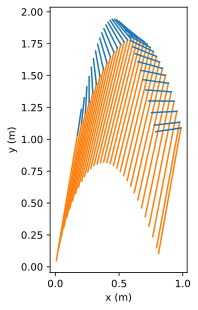

In [664]:
fig, ax = plt.subplots()

len_a = physical_params[r2.la]
len_b = physical_params[r2.lb]

# ax.plot([y[0] for y in ys], [y[1] for y in ys])
for q1, q2, th1, th2, *_ in ys:
    ax.plot([q1 - len_a / 2 * np.sin(th1), q1 + len_a / 2 * np.sin(th1)], [q2 - len_a / 2 * np.cos(th1), q2 + len_a / 2 * np.cos(th1)], c='C1')
    ax.plot([q1 + len_a / 2 * np.sin(th1), q1 + len_a / 2 * np.sin(th1) + len_b * np.sin(th1 + th2)],
            [q2 + len_a / 2 * np.cos(th1), q2 + len_a / 2 * np.cos(th1) + len_b * np.cos(th1 + th2)],
            c='C0')

ax.set_aspect('equal')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

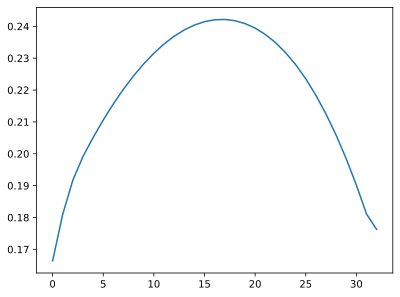

In [665]:
fig, ax = plt.subplots()

ax.plot([y[2] for y in ys])

In [606]:
len(ys)

33